In [1]:
import torch 
import torch.nn as nn
# import torch.nn.init as init
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.utils.data as data

import sys
import numpy as np
from scipy.stats import levy_stable
import datetime
from torch.utils.checkpoint import checkpoint

from scipy import optimize
from scipy import integrate


%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 5
step_size = 5e-1  # 5e-2 # step size
n_pts = 50000      # number of points
alpha = 1.5

n_x=50 #number of different x

#n_layers = 2
n_hidden_dim = 25

n_input_dim = 1
n_output_dim = 1 

BATCH_SIZE = 512


def setup_seed(seed):
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    #torch.backends.cudnn.deterministic = True

In [3]:
# added: data generation 
setup_seed(random_seed)
class SDEIntegrators:
    """
    Implements the common Euler-Maruyama 
    scheme used in integration of SDE.
    """

    def __init__(self):
        pass

    
    @staticmethod
    def euler_maruyama(xn, h, _f_sigma, rng):
        
        #np.random.seed(random_seed)
        dL = levy_stable.rvs(alpha=alpha, beta=0, size=xn.shape, scale=h**(1/alpha))    # added for levy 
        
        xk = xn.reshape(1, -1)  # we only allow a single point as input

        fk, sk = _f_sigma(xk)
        if np.prod(sk.shape) == xk.shape[-1]:
            skL = sk * dL  
        else:
            sk = sk.reshape(xk.shape[-1], xk.shape[-1])
            skL = ((sk @ dL.T).T)
            
        return xk + h * fk + skL   # added for levy 

    
def sample_data(drift_diffusivity, step_size, n_dimensions, low, high, n_pts, rng, n_subsample=1):
#     x_data = rng.uniform(low=low, high=high, size=(n_pts, n_dimensions))
#     x_data = np.zeros((n_pts, n_dimensions), dtype=np.float64) 
#     x_data1 = np.linspace(low, 0, np.int(n_x/3))
#     x_data2 = np.linspace(0, high, np.int(2 * n_x/3))
#     x_data = np.concatenate((x_data1, x_data2)) 
#     x_data = np.repeat(x_data[:(n_x+1)],n_pts/n_x).reshape(-1,n_dimensions)
    x_data = np.linspace(low, high, n_x+1)
    x_data = np.repeat(x_data[:-1],n_pts/n_x).reshape(-1,n_dimensions)
    y_data = x_data.copy()
    for k in range(n_subsample):
        y_data = np.row_stack([
            SDEIntegrators.euler_maruyama(y_data[k, :],
                                          step_size / n_subsample,
                                          drift_diffusivity,
                                          rng)
            for k in range(x_data.shape[0])
        ])

    return x_data, y_data


# EXAMPLE 1
def true_drift(x):
    return x-x**3



def true_diffusivity(x):
    return np.sin(np.pi*x) + 1.


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_input_dim,
                             low=-1, high=1, n_pts=n_pts,
                             rng=rng)
print('data shape', x_data.shape)

#trick
y_mean = np.array([])
y_median = np.array([])
x_mean = np.array([])
for i in range(n_x):
    yi_mean = np.mean(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),0])
    yi_median = np.median(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),0])
    xi_mean = x_data[i*np.int(n_pts/n_x),0]
    y_mean = np.append(y_mean, yi_mean)
    y_median = np.append(y_median, yi_median)
    x_mean = np.append(x_mean, xi_mean)

y_mean = y_mean.reshape(-1,1)
y_median = y_median.reshape(-1,1)
x_mean = x_mean.reshape(-1,1)


data shape (50000, 1)


In [4]:
#trick2
y_mean2 = np.array([])

for i in range(n_x):
    yi_mean = np.mean(np.sort(y_data.ravel()[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x))])[400:600])
    y_mean2 = np.append(y_mean2, yi_mean)
    
y_mean2 = y_mean2.reshape(-1,1)

In [5]:
#network initialization
small_init=1e-2
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias,0.1)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data,-small_init,small_init)
        nn.init.uniform_(m.bias,-small_init,small_init)

In [6]:
#network structure
class FCNN1(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN1,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.hidden3(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)

        return out
    
class FCNN2(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN2,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)
        out = torch.nn.functional.softplus(out) + torch.tensor([1e-13])

        return out




In [7]:
# ms_model = FCNN(n_input_dim, n_output_dim, n_hidden_dim)
mean_model = FCNN1(n_input_dim, n_output_dim, n_hidden_dim)
std_model = FCNN2(n_input_dim, n_output_dim, n_hidden_dim)

# weight_init(ms_model)
weight_init(std_model)

# optimizer = optim.Adamax(ms_model.parameters(), lr=0.005,eps=1e-07)
optimizer1 = optim.Adam(mean_model.parameters(), lr=0.005)
optimizer2 = optim.Adamax(std_model.parameters(),lr=0.005, eps=1e-07)
#optimizer2 = optim.Adamax(std_model.parameters(),lr=0.001, eps=1e-07)
#mean_model,std_model

In [8]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in numpy
import math
def pdf_zolotarev(x, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    
    if alpha != 1:
        x0 = x   # convert to S_0 parameterization
        
        def V(theta):
            return (np.cos(theta)/np.sin(alpha*theta))**(alpha/(alpha-1)) * \
                    (np.cos((alpha-1)*theta)/np.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) *
                        np.real(np.complex128(x0)**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * np.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences

            with np.errstate(all="ignore"):
                intg_max = optimize.minimize_scalar(lambda theta: -f(theta), bounds=[0, np.pi/2])
                intg_kwargs = {}
                # windows quadpack less forgiving with points out of bounds
                if intg_max.success and not np.isnan(intg_max.fun)\
                        and intg_max.x > 0 and intg_max.x < np.pi/2:
                    intg_kwargs["points"] = [intg_max.x]
                intg = integrate.quad(f, 0, np.pi/2, **intg_kwargs)[0]
                return alpha * intg / np.pi / np.abs(alpha-1) / x0
        elif x0 == 0:
            return math.gamma(1+1/alpha)/np.pi
        else:
            return pdf_zolotarev(-x, alpha)
r=pdf_zolotarev(1);r

0.20203815960784008

In [9]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in torch
import math
def pdf_zolotarev2(x0, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    small_value = torch.Tensor([1e-8])
    
    if alpha != 1:
        #x0 = x   # convert to S_0 parameterization
        #x0 = torch.tensor([x], dtype=torch.float32, requires_grad=True)
        def V(theta):
            if alpha > 1:
                if torch.sin(alpha*theta) == 0 or torch.cos(theta) == 0:
                    return (torch.cos(theta)/(torch.sin(alpha*theta) + small_value))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta) + small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
            else:
                if theta == torch.tensor([np.pi/2]):
                    return ((torch.cos(theta)+small_value)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta)+small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) * x0 **(alpha/(alpha-1)))
#                         torch.real(torch.complex(x0,torch.Tensor([0.]))**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * torch.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences
            intg_n = 100 
            theta = torch.linspace(0., np.pi/2, intg_n+1)
            ff = torch.zeros_like(theta, dtype=torch.float32)
            for i in range(theta.shape[0]):
                ff[i] = f(theta[i])
        
#             fnotnan = ff>=0
#             fnan =~fnotnan
#             ff = torch.where(fnan, torch.zeros_like(ff,dtype=torch.float32), ff)
            intg = 0
            for i in range(intg_n):
                intg += (ff[i + 1] + ff[i]) * (theta[1] - theta[0]) / 2

            
            return alpha * intg / np.pi / np.abs((alpha-1))/ x0
        elif x0 == 0:
            return torch.Tensor([math.gamma(1+1/alpha)/np.pi]) + 0*x0
        else:
            return pdf_zolotarev2(-x0, alpha)
        
t=torch.tensor([1.],requires_grad=True)
r=pdf_zolotarev2(t);r.backward()
print(r,t.grad)
#r=pdf_zolotarev2(69814);r

tensor([0.2020], grad_fn=<DivBackward0>) tensor([-0.1356])


In [10]:
#S_alpha(h**(1/alpha)*sigma(x),0,x+f(x)*h) pdf
def alpha_stable_pdf(yn, ynp1, step_size_, drift_, diffusivity_, alpha=alpha):
    
    f_alpha = torch.zeros_like(torch.Tensor(yn))
    ynp1_std = ((ynp1-yn-step_size_*drift_)/(step_size_**(1/alpha)*diffusivity_))
    for k in range(yn.shape[0]):
        f_alpha[k] = pdf_zolotarev2(ynp1_std[k])


    return f_alpha/(step_size_**(1/alpha)*diffusivity_)

In [11]:
#different loss
def log_prob_loss(mean, std, step_size, x, y):
    
    y_dist = alpha_stable_pdf(x ,y, step_size, mean.reshape(-1,1), std.reshape(-1,1))
    y_log_prob = -torch.log(y_dist)
    return y_log_prob

def abs_loss(mean, std, step_size, x, y):
    dL = levy_stable.rvs(alpha=alpha, beta=0, size=x.shape, scale=step_size**(1/alpha))
    absloss = torch.abs(y - (x + mean.reshape(-1,1) * step_size + std.reshape(-1,1) * torch.Tensor(dL)))
    
    return absloss

def square_loss(mean, step_size, x, y):
#     dL = levy_stable.rvs(alpha=alpha, beta=0, size=x.shape, scale=step_size**(1/alpha))
    absloss = torch.square(y - (x + mean.reshape(-1,1) * step_size))# + std.reshape(-1,1) * torch.Tensor(dL)))
    
    return absloss


epoch: 1 Loss: tensor(0.0251, grad_fn=<MeanBackward0>)
tensor([[-0.1251],
        [-0.1187],
        [-0.1122],
        [-0.1056],
        [-0.0990],
        [-0.0924],
        [-0.0859],
        [-0.0793],
        [-0.0728],
        [-0.0662],
        [-0.0596],
        [-0.0531],
        [-0.0467],
        [-0.0404],
        [-0.0342],
        [-0.0280],
        [-0.0220],
        [-0.0161],
        [-0.0103],
        [-0.0046],
        [ 0.0010],
        [ 0.0065],
        [ 0.0118],
        [ 0.0170],
        [ 0.0221],
        [ 0.0270],
        [ 0.0318],
        [ 0.0364],
        [ 0.0408],
        [ 0.0451],
        [ 0.0492],
        [ 0.0531],
        [ 0.0569],
        [ 0.0606],
        [ 0.0643],
        [ 0.0678],
        [ 0.0713],
        [ 0.0747],
        [ 0.0780],
        [ 0.0813],
        [ 0.0846],
        [ 0.0878],
        [ 0.0909],
        [ 0.0940],
        [ 0.0971],
        [ 0.1001],
        [ 0.1030],
        [ 0.1059],
        [ 0.1087],
        [ 0.11

epoch: 45 Loss: tensor(0.0066, grad_fn=<MeanBackward0>)
tensor([[-0.2951],
        [-0.2933],
        [-0.2910],
        [-0.2882],
        [-0.2849],
        [-0.2809],
        [-0.2764],
        [-0.2711],
        [-0.2651],
        [-0.2584],
        [-0.2508],
        [-0.2423],
        [-0.2328],
        [-0.2224],
        [-0.2111],
        [-0.1988],
        [-0.1854],
        [-0.1708],
        [-0.1550],
        [-0.1379],
        [-0.1194],
        [-0.0997],
        [-0.0788],
        [-0.0570],
        [-0.0349],
        [-0.0126],
        [ 0.0097],
        [ 0.0317],
        [ 0.0535],
        [ 0.0751],
        [ 0.0965],
        [ 0.1176],
        [ 0.1383],
        [ 0.1586],
        [ 0.1785],
        [ 0.1979],
        [ 0.2168],
        [ 0.2352],
        [ 0.2532],
        [ 0.2707],
        [ 0.2878],
        [ 0.3044],
        [ 0.3206],
        [ 0.3364],
        [ 0.3517],
        [ 0.3667],
        [ 0.3813],
        [ 0.3955],
        [ 0.4094],
        [ 0.4

epoch: 121 Loss: tensor(0.0022, grad_fn=<MeanBackward0>)
tensor([[-0.1254],
        [-0.1490],
        [-0.1724],
        [-0.1953],
        [-0.2177],
        [-0.2392],
        [-0.2595],
        [-0.2785],
        [-0.2958],
        [-0.3114],
        [-0.3249],
        [-0.3361],
        [-0.3445],
        [-0.3498],
        [-0.3516],
        [-0.3492],
        [-0.3418],
        [-0.3274],
        [-0.3057],
        [-0.2763],
        [-0.2391],
        [-0.1941],
        [-0.1411],
        [-0.0854],
        [-0.0298],
        [ 0.0253],
        [ 0.0787],
        [ 0.1290],
        [ 0.1754],
        [ 0.2174],
        [ 0.2546],
        [ 0.2857],
        [ 0.3110],
        [ 0.3309],
        [ 0.3459],
        [ 0.3565],
        [ 0.3630],
        [ 0.3656],
        [ 0.3646],
        [ 0.3603],
        [ 0.3531],
        [ 0.3430],
        [ 0.3305],
        [ 0.3158],
        [ 0.2989],
        [ 0.2802],
        [ 0.2596],
        [ 0.2374],
        [ 0.2136],
        [ 0.

epoch: 190 Loss: tensor(0.0019, grad_fn=<MeanBackward0>)
tensor([[-0.0503],
        [-0.0923],
        [-0.1332],
        [-0.1728],
        [-0.2107],
        [-0.2465],
        [-0.2794],
        [-0.3090],
        [-0.3340],
        [-0.3540],
        [-0.3689],
        [-0.3784],
        [-0.3823],
        [-0.3801],
        [-0.3724],
        [-0.3598],
        [-0.3426],
        [-0.3207],
        [-0.2941],
        [-0.2622],
        [-0.2259],
        [-0.1879],
        [-0.1481],
        [-0.1068],
        [-0.0648],
        [-0.0220],
        [ 0.0214],
        [ 0.0658],
        [ 0.1104],
        [ 0.1540],
        [ 0.1957],
        [ 0.2343],
        [ 0.2695],
        [ 0.3012],
        [ 0.3287],
        [ 0.3507],
        [ 0.3652],
        [ 0.3725],
        [ 0.3730],
        [ 0.3674],
        [ 0.3561],
        [ 0.3396],
        [ 0.3185],
        [ 0.2931],
        [ 0.2640],
        [ 0.2313],
        [ 0.1953],
        [ 0.1564],
        [ 0.1148],
        [ 0.

epoch: 269 Loss: tensor(0.0017, grad_fn=<MeanBackward0>)
tensor([[-0.0113],
        [-0.0633],
        [-0.1138],
        [-0.1624],
        [-0.2086],
        [-0.2512],
        [-0.2878],
        [-0.3182],
        [-0.3421],
        [-0.3593],
        [-0.3697],
        [-0.3732],
        [-0.3701],
        [-0.3613],
        [-0.3478],
        [-0.3295],
        [-0.3064],
        [-0.2807],
        [-0.2536],
        [-0.2251],
        [-0.1951],
        [-0.1635],
        [-0.1296],
        [-0.0905],
        [-0.0471],
        [-0.0026],
        [ 0.0425],
        [ 0.0875],
        [ 0.1324],
        [ 0.1768],
        [ 0.2200],
        [ 0.2607],
        [ 0.2978],
        [ 0.3311],
        [ 0.3600],
        [ 0.3844],
        [ 0.4035],
        [ 0.4141],
        [ 0.4166],
        [ 0.4119],
        [ 0.4004],
        [ 0.3829],
        [ 0.3601],
        [ 0.3323],
        [ 0.3001],
        [ 0.2638],
        [ 0.2238],
        [ 0.1803],
        [ 0.1336],
        [ 0.

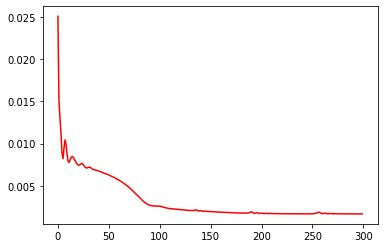

Time used: 0.919513300000002


In [12]:
#step1 for drift
tis1 = time.perf_counter()    
epoch = 300


Loss = np.array([])

x_mean1, y_mean1 = torch.from_numpy(x_mean).float(), torch.from_numpy(y_mean2).float()
train_dataset = data.TensorDataset(x_mean1, y_mean1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=1000000,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        approx_mean = mean_model((batch_x))[:, 0]
#         approx_std = ms_model((batch_x))[:, 1]
#         log_prob = log_prob_loss(approx_mean, step_size, batch_x, batch_y)
        absloss = square_loss(approx_mean, step_size, batch_x, batch_y)
        loss = torch.mean(absloss)#+absloss)
        loss.backward()
        optimizer1.step()
        #optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(mean_model(torch.Tensor(x_mean)))
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

In [13]:
#step2 for diffusion
tis1 = time.perf_counter()    
epoch = 26


Loss = np.array([])

x_data1, y_data1 = torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float()
train_dataset = data.TensorDataset(x_data1, y_data1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
#         optimizer.zero_grad()
        optimizer2.zero_grad()
        approx_mean = mean_model((batch_x))[:, 0]
        approx_std = std_model((batch_x))[:, 0]
        log_prob = log_prob_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
#         absloss = abs_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
        loss = torch.mean(log_prob)#+absloss)
        loss.backward()
        optimizer2.step()
        #optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(std_model(torch.Tensor(x_data))[::1000])
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

KeyboardInterrupt: 

In [ ]:
def plot_results_functions(mean_network, std_network, true_drift_diffusivity,
                           x_data, y_data, rng):


    mean_network = mean_network.detach().numpy()
    std_network = std_network.detach().numpy()

    n_dimensions = x_data.shape[1]  

    ms = 0.2  # marker size

    true_drift_evaluated, true_std_evaluated = true_drift_diffusivity(x_data)

    if n_dimensions == 1:
        mean_network = mean_network.reshape(-1, 1)
        std_network = std_network.reshape(-1, 1)
        
        idx_ = np.argsort(x_data.ravel()) 

        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].plot(x_data[idx_], true_drift_evaluated[idx_], "-", color="gray", label="true")
        ax[0].plot(x_data[idx_], mean_network[idx_, 0], "+", markevery=len(x_data)//21, color='magenta', label="approximated")   
        ax[0].set_xlabel("Space")
        ax[0].set_ylabel("Drift")
        ax[0].legend()

        ax[1].plot(x_data[idx_], true_std_evaluated[idx_], "-", color="gray", label="true")
        ax[1].plot(x_data[idx_], std_network[:, 0], "+", markevery=len(x_data)//21, color='magenta', label="approximated")
        ax[1].set_xlabel("Space")
        ax[1].set_ylabel("Diffusivity")
        ax[1].legend()
        ax[1].set_ylim([0.01,2.1])
    else:
        fig, ax = plt.subplots(2, n_dimensions, figsize=(n_dimensions * 3, 6))

        for k in range(n_dimensions):
            identity_pts = np.linspace(np.min([np.min(mean_network[:, k]), np.min(true_drift_evaluated)]),
                                       np.max([np.max(mean_network[:, k]), np.max(true_drift_evaluated)]),
                                       10)

            ax[0, k].scatter(mean_network[:, k], true_drift_evaluated[:, k], s=ms, label="approximation")
            ax[0, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[0, k].set_xlabel(r"network drift $f_" + str(k + 1) + "$")
            ax[0, k].set_ylabel(r"true drift $f_" + str(k + 1) + "$")
            ax[0, k].legend()

            identity_pts = np.linspace(np.min([np.min(std_network[:, k]), np.min(true_std_evaluated)]),
                                       np.max([np.max(std_network[:, k]), np.max(true_std_evaluated)]),
                                       10)

            ax[1, k].scatter(std_network[:, k], true_std_evaluated[:, k], s=ms, label="approximation")
            ax[1, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[1, k].set_xlabel(r"network diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].set_ylabel(r"true diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].legend()
    fig.tight_layout()   
#     fig.savefig('_sin_pi_x_+1_noise.eps',dpi=900,format='eps')
    return ax






In [ ]:
#figure

rng = np.random.default_rng(random_seed)
estimated_ms = mean_model(x_data1)
estimated_std = std_model(x_data1)
ax = plot_results_functions(estimated_ms[:,0], estimated_std[:,0], true_drift_diffusivity,
                            x_data, y_data, rng)
ax[1].set_ylim([-0.5,2.3])

In [ ]:
#L2loss
L2lossf=torch.mean(torch.square(estimated_ms-torch.tensor(true_drift(x_data))))
L2lossg=torch.mean(torch.square(estimated_std-torch.tensor(true_diffusivity(x_data))))
print(L2lossf,L2lossg)